# How to Access Forecast Data from the National Water model 

<strong><em>Created by Ayman Alafifi, Brown and Caldwell. 2022</em></strong><br>
<em><strong>

<strong><em>Special thanks to <a href="https://www.linkedin.com/in/justin-hunter-0b86871a6/" target="_blank">Justin Hunter</a>, <a href="https://www.linkedin.com/in/danames/" target="_blank">Dr. Dan Ames</a>, and <a href="https://www.linkedin.com/in/easton-perkins-02968a156/" target="_blank">Easton Perkins</a> for providing query functions on HydroShare.</em></strong>

Forecast data from the National Water Model (NWM) are available from two sources:

1. The full set of NWM output data and a subset of forcing files is available on NOAA Operational Model Archive and Distribution System (NOMADS) HTTP service. This web server includes NWM forecast for all 2.7 million stream segments across the CONUS, but the data is only stored for the current and previous day's NWM forecasts.

2. A subset of the NWM output data for about 7500 NWM reaches that have an associated USGS gauges are available on a Google Cloud Storage here.  Data from September of 2018 through today is available there.


This jupyter notebook provides instructions and examples to guide users on how to download and acess the data from these two sources.

<em><h3>NOMADs Dataset</h3></em>

Data from NOMADS can be accessed from this site:
https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/

In [6]:
#import libraries for data query and plotting

from datetime import date
import os
import requests
import xarray as xr
import matplotlib.pyplot as plt
# Set-up inline plots using matplotlib
%matplotlib inline

<em><h4>Create query functions</h4></em>

The next code cell defines three functions that are used in the notebook. Short descriptions are provided next to each function as Python comments.The first function builds the URL for a given forecast. The next function downloads the given forecast from NOAA. The third function gets a time series of data for a given stream segment and uses the first two functions to get the necessary forecasts.

In [7]:
# This function builds the url for a specific forecast from the NOAA NWM http file delivery index (https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/)
# The urls are similar to this one: 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.20210320/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc'
def GetForecastFileName(ForecastStartDate = '20210321', ForecastStartTimestep='00', ForecastType = 'short_range', ForecastMember='1', TimeStep = '001'):
  BaseName = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.'

  # The Different forecast types have slightly different urls. The following 'if elif' statements help build valid urls based on the forecast type given to the function.
  if (ForecastType == 'short_range'):
    return BaseName + ForecastStartDate + '/short_range/nwm.t' + ForecastStartTimestep +'z.short_range.channel_rt.f' + TimeStep + '.conus.nc'
  elif (ForecastType == 'medium_range'): 
    return BaseName + ForecastStartDate + '/medium_range_mem' + ForecastMember + '/nwm.t' + ForecastStartTimestep +'z.medium_range.channel_rt_' + ForecastMember + '.f' + TimeStep + '.conus.nc'
  elif (ForecastType == 'long_range'):
    return BaseName + ForecastStartDate + '/long_range_mem' + ForecastMember + '/nwm.t' + ForecastStartTimestep +'z.long_range.channel_rt_' + ForecastMember + '.f' + TimeStep + '.conus.nc'
  else:
    return 'error'


# This function downloads the given forecast file from NOAA using its url. You can see that we use os to communicate with the operating system and requests to 'get' what is at that url.
def GetForecastFile(Url = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.20210321/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc'):
  FileName = os.path.basename(Url)
  if os.path.exists(FileName):
    os.remove(FileName)
  r = requests.get(Url, allow_redirects=True)
  open(FileName, 'wb').write(r.content)
  
  return FileName


# This last function gets a time series of data for a stream segment by looping through and grabbing the forecast files at every time interval until the full forecast has been retrieved and added to the series.
# For example, a short range forecast is 18 hours long and has 18 1-hr intervals that need to be retrieved to build the full time series.
# This function only grabs every third forecast for medium range forecasts. That means that the range is 80 for member 1 and 68 for other members. That results in 240-hr (10-day) and 204-hr (8.5 hour) forecasts respectively.
# Long range forecasts have 6-hr intervals which extend out to 30 days (720 hours). That means that the range is 120 (720/6).
def GetSeries(StreamID = 23275226, ForecastStartDate = '20210321', ForecastStartTimestep='00', ForecastType = 'short_range', ForecastMember='1'):
  TimeSteps = []
  TimeSteps.clear()
  Series = []
  Series.clear()
  if (ForecastType=='short_range'):
    for i in range(18):
      TimeSteps.append("%03d" % (i+1))
  elif (ForecastType=='medium_range' and ForecastMember=='1'):
    for i in range(80):
      TimeSteps.append("%03d" % ((i+1)*3))
  elif (ForecastType=='medium_range' and ForecastMember!='1'):
    for i in range (68):
      TimeSteps.append("%03d" % ((i+1)*3))
  elif (ForecastType=='long_range'):
    for i in range(120):
      TimeSteps.append("%03d" % ((i+1)*6))
  else: 
    return 'Error building time steps'
  
  for ts in TimeSteps:
    MyUrl = GetForecastFileName(ForecastStartDate,ForecastStartTimestep, ForecastType,ForecastMember,ts)
    FileName = GetForecastFile(MyUrl)
    if(FileName != 'error'):
      data = xr.open_dataset(FileName)
      Q = float(data.sel(feature_id=StreamID).streamflow.values)
      Series.append(Q)
    else:
      print('Error getting forecast files.')
    
  return Series

<em><h4>Define variables for the query functions</h4></em>

In [8]:
# This gets todays date, stores it in yyyymmdd format and assigns it to the variable 'today' which we can use in the next cell
# Note: for NOMAD data, only forecast start date of today and yesterday are available. 
# For historical data, see Google bucket functions below 
today = date.today()
print(today)
today = str(today)
today = today.replace("-", "")
print(today)

2022-07-30
20220730


In [15]:
# Variables
# The unique identifier corresponding to a river segment:
StreamID = 23275226

# Date in YYYYMMDD format. Can only be today or yesterday. Here the variable 'today' is called from the previous cell.
# If you do decide to change this variable be sure to put your date in as a string by placing it inside of quotes like this: 'YYYYMMDD' 
ForecastStartDate = today  

# Timestep forecast was issued, 00 = midnight CST (Central Standard Time), Cannot exceed 24, 
# Cannot be in the future (Example: Today two hours from now)
# For short_range can be 00, 01, 02, 03, etc.
# For medium_range or long_range can be 00, 06, 12, etc.:
ForecastStartTimestep = '00'       

# Options are 'short_range', 'medium_range', and 'long_range':
ForecastType = 'medium_range'       

# Should be 1 for short_range. If using medium_range or 'long_range' then specify the ensemble member 
# (1-4 for long_range or 1-7 for medium_range):
ForecastMember = '1'  


# Now we use the GetSeries function from above, and provide it with the appropriate arguments using the variables that were just created.
Series = GetSeries(StreamID, ForecastStartDate, ForecastStartTimestep, ForecastType, ForecastMember)
print(Series)

# If this cell gives an error, double check that you've passed valid variables and run it again.

[179.8099959809333, 179.53999598696828, 179.30999599210918, 179.13999599590898, 179.0099959988147, 178.91999600082636, 178.8399960026145, 178.74999600462615, 178.57999600842595, 178.17999601736665, 177.3399960361421, 175.7899960707873, 173.3199961259961, 169.8299962040037, 165.339996304363, 159.9999964237213, 154.0299965571612, 147.6599966995418, 141.13999684527516, 134.60999699123204, 128.22999713383615, 122.17999726906419, 116.5499973949045, 111.38999751023948, 106.70999761484563, 102.51999770849943, 98.8599977903068, 95.76999785937369, 93.32999791391194, 91.64999795146286, 90.9399979673326, 91.42999795638025, 93.48999791033566, 97.46999782137573, 103.76999768055975, 112.49999748542905, 123.64999723620713, 136.9899969380349, 151.87999660521746, 167.43999625742435, 182.7499959152192, 196.90999559871852, 209.82999530993402, 221.7199950441718, 232.6899947989732, 242.82999457232654, 252.25999436154962, 261.08999416418374, 269.35999397933483, 277.10999380610883, 284.32999364472926, 290.99

<em><h4>Plotting</h4></em>

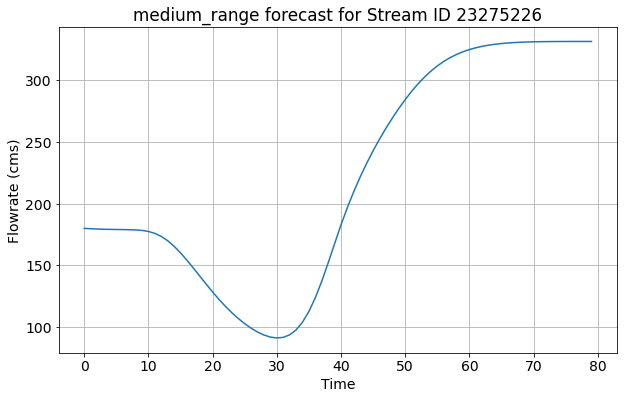

In [10]:
# Plot the series and explore what it looks like
plt.rc('font', size=14)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(Series, color='tab:blue', label='Streamflow')
ax.set_xlabel('Time')
ax.set_ylabel('Flowrate (cms)')
ax.set_title(ForecastType + ' forecast for Stream ID ' + str(StreamID))
ax.grid(True)


In [16]:
# Build forecast url and get forecast file using the previously defined functions
url = GetForecastFileName(today, ForecastStartDate,ForecastType,ForecastMember,ForecastStartTimestep)
path = GetForecastFile(url)
print(path)

nwm.t20220730z.medium_range.channel_rt_1.f00.conus.nc


In [17]:
# Use the path and xarray to create a dataframe. This is easier to work with than a series of values

# Open the NWM NetCDF file as an xarray dataset
ds = xr.open_dataset(path)
type(ds)
ds

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'cfgrib', 'pseudonetcdf', 'pydap']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [ ]:
# Extract the streamflow values from the dataset as a dataarray
streamflow = ds["streamflow"]

#convert to dataframe
streamflow_df = streamflow.to_dataframe()


NetCDF files are typically large and can take up space on your desk, so the next cell is handy to erase the forecast files that were downloaded previously. The cell is also written so that it will print out the name of each file that it removes/deletes.

In [ ]:
files = [f for f in os.listdir('.') 
         if os.path.isfile(f)]

for f in files:
    # Delete leftover netcdf files 
    if "nwm" in f and f.endswith(".conus.nc"):
        print(f)
        os.remove(f)

<em><h3>Google Cloud Platform (GCP) NWM Dataset</h3></em>

In this section, we query historical NWM data from GCP.Data from September of 2018 through today is avaible here:
https://console.cloud.google.com/storage/browser/national-water-model;tab=objects?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false

To access the data on GCP, we will use HydroTools. Hydrotools only returns NWM reaches that have an associated USGS gauge. 7500+ reaches of the National Water Model are available via Hydrotools. Hydrotools is described as a suite of tools for retrieving USGS NWIS observations and evaluating NWM data. Documentation can be viewed at https://noaa-owp.github.io/hydrotools/.


In [20]:
# Install from here:
#!pip install hydrotools.nwm_client[gcp]

#Then import the libraries:
from hydrotools.nwm_client import http as nwm
from hydrotools.nwm_client import gcp
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
from functools import reduce

In [21]:
# Specify service
service=gcp.NWMDataService()
# Print out possible configurations
print(service.configurations)

['analysis_assim', 'analysis_assim_extend', 'analysis_assim_hawaii', 'analysis_assim_long', 'analysis_assim_puertorico', 'long_range_mem1', 'long_range_mem2', 'long_range_mem3', 'long_range_mem4', 'medium_range_mem1', 'medium_range_mem2', 'medium_range_mem3', 'medium_range_mem4', 'medium_range_mem5', 'medium_range_mem6', 'medium_range_mem7', 'short_range', 'short_range_hawaii', 'short_range_puertorico', 'analysis_assim_no_da', 'analysis_assim_extend_no_da', 'analysis_assim_hawaii_no_da', 'analysis_assim_long_no_da', 'analysis_assim_puertorico_no_da', 'medium_range_no_da', 'short_range_hawaii_no_da', 'short_range_puertorico_no_da']


In [22]:
start_date = "20201114T00Z"

In [23]:
from hydrotools.nwm_client import gcp as nwm

#Query all data for all reaches for this start data
df_med1 = service.get(
    configuration = "medium_range_mem1", 
    reference_time = start_date 
)

In [ ]:
# Next, subset the data for desired reaches

# Create a list with my desired reach ids
myreaches_list = ['07079300', '07081200', '07083000', '07134100' ]

In [ ]:
# Initialize an empty DataFrame
ark_med1 = pd.DataFrame()

# Add each reach's forecast from the DataFrame we retrieved from GCP to our new DataFrame
for i in myreaches_list:
    x = df_med1.loc[df_med1["usgs_site_code"]==i]
    ark_med1 = pd.concat([ark_med1,x])